In [1]:
# Main Imports
from ipynb.fs.full.GastricFunctions import *
#from GastricFunctions_py import *
import numpy as np
import pandas as pd
# Util function for convert-to (0 - 1) range
def rescale(arr):
    arr_min = arr.min()
    arr_max = arr.max()
    return (arr - arr_min) / (arr_max - arr_min)

def rescale_AB(arr):
    arr_min = arr.min()
    arr_max = arr.max()
    return ( (arr - arr_min) / (arr_max - arr_min)  ) * 255 - 128

In [2]:
# Loading Results dataframe
# Prepare this dataframe (total results) only once
# total_results_dataframe = pd.DataFrame(columns=["Patient to be predicted/left out" , "Poor Survival Subpopulation" , "Moderate Survival Subpopulation" , "Good Survival Subpopulation", "Predicted Survivability", "Surv(months)" , "Survival Status" , "Number of Clusters"  , "SAM Features for each tSNE run on new subset"])
total_results_dataframe_SVM = pd.DataFrame(columns=["Patient to be predicted/left out" , "Poor Survival Subpopulation" , "Moderate Survival Subpopulation" , "Good Survival Subpopulation", "Predicted Survivability", "Surv(months)" , "Survival Status" , "Number of Clusters"  , "SAM Features for each tSNE run on new subset"])
total_results_dataframe_KNN = pd.DataFrame(columns=["Patient to be predicted/left out" , "Poor Survival Subpopulation" , "Moderate Survival Subpopulation" , "Good Survival Subpopulation", "Predicted Survivability", "Surv(months)" , "Survival Status" , "Number of Clusters"  , "SAM Features for each tSNE run on new subset"])

# Only load if needed to load total results from previous runs to continue on
# total_results_dataframe_SVM = pd.read_csv("total_GastricCancer_results_SVM.csv")
# total_results_dataframe_KNN = pd.read_csv("total_GastricCancer_results_KNN.csv")


In [3]:
# Reading Data
HE_image , MSI_data_cube , goodlist, peak_list, pixel_to_sample_ID, sample_only_data, sample_ID_pixels = ReadGastricData()

In [4]:
## Selecting Patient as test
testPatient_ID = 2
#-------------------------------------------------------
# Splitting data into train and test and scaled and non_scaled
train_scaled_data,train_data,train_ID_pixels,test_scaled_data,test_data,test_ID_pixels = SplitData(ID = testPatient_ID , sample_only_data = sample_only_data, sample_ID_pixels = sample_ID_pixels )

In [ ]:
for i in range(1,64):
    ## Selecting Patient as test
    testPatient_ID = i
    #-------------------------------------------------------
    # Splitting data into train and test and scaled and non_scaled
    train_scaled_data,train_data,train_ID_pixels,test_scaled_data,test_data,test_ID_pixels = SplitData(ID = testPatient_ID ,
            sample_only_data = sample_only_data,
            sample_ID_pixels = sample_ID_pixels )

    scaler = MinMaxScaler()
    train_normalized_data = scaler.fit_transform(train_data)

    # Run tSNE Model
    tsne_results = tSNE(train_normalized_data)
    np.save("patient_TSNE/BreastCancer_tSNE_Normalized_Model_Patient_{}".format(testPatient_ID) , tsne_results)

In [ ]:
# Run tSNE Model
tsne_results = tSNE(train_scaled_data)
np.save("patient_TSNE/GastricCancer_tSNE_Model_Patient_{}".format(testPatient_ID) , tsne_results)

In [5]:
# Load tSNE model instead of running model if needed
tsne_results = np.load("patient_TSNE/GastricCancer_tSNE_Model_Patient_{}.npy".format(testPatient_ID))

C:\Users\omars\anaconda3\lib\site-packages\skimage\color\colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 2053 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


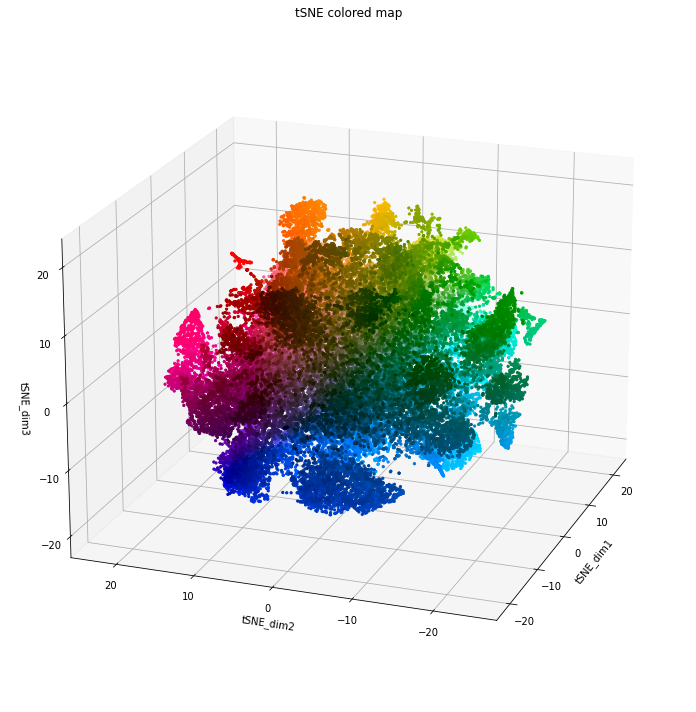

In [6]:
# Visualize tSNE
tsne_df = pd.DataFrame(data=tsne_results[:],columns=["tSNE_dim1","tSNE_dim2","tSNE_dim3"])
tsne_df['pixel_ID'] = train_ID_pixels
tsne_df['L_Component'] = tsne_results[:,0]
tsne_df['A_Component'] = tsne_results[:,1]
tsne_df['B_Component'] = tsne_results[:,2]

# Converting tSNE dimensions to be represented 

LAB_mapping = [ tsne_df['L_Component'] , tsne_df['A_Component'] , tsne_df['B_Component'] ]
LAB_colors = np.asarray(LAB_mapping)
LAB_colors = LAB_colors.swapaxes(0,1)

L = rescale(LAB_colors[:,0]) * 100
A = rescale_AB(LAB_colors[:,1])
B = rescale_AB(LAB_colors[:,2])
LAB_colors = np.asarray( [ L , A , B ] )
LAB_colors = LAB_colors.swapaxes(0,1)
RGB_colors = lab2rgb(LAB_colors)

ax = plt.figure(figsize=(16,10)).gca(projection='3d')
scatter_3d = ax.scatter(
    xs=tsne_df['tSNE_dim1'], 
    ys=tsne_df['tSNE_dim2'], 
    zs=tsne_df['tSNE_dim3'], 
    c = RGB_colors,
    s = 5,
    alpha = 1,
)

ax.set_xlabel('tSNE_dim1')
ax.set_ylabel('tSNE_dim2')
ax.set_zlabel('tSNE_dim3')
ax.set_title("tSNE colored map")

# fig.subplots_adjust(left=0, right=1, bottom=0, top=1)

# elev is z-axis, +ve moves up, -ve moves down
# azim is x axis, +ve moves right, -ve moves left
ax.view_init(elev = 20 , azim = -160) 
plt.tight_layout()

In [7]:
# Applying KMeans from 3 to 8 clusters
kmeans_3 , kmeans_4, kmeans_5, kmeans_6, kmeans_7, kmeans_8 = KMeans_results(tsne_results)

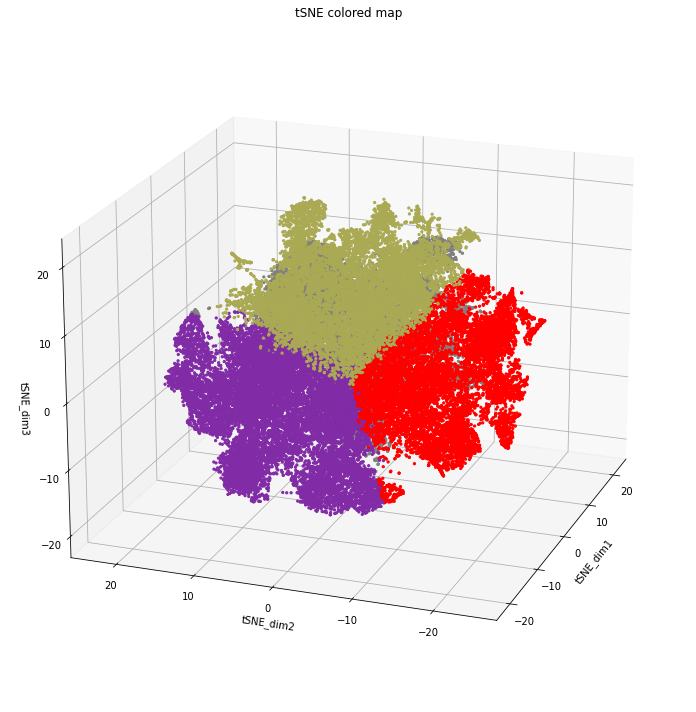

In [8]:
labels = kmeans_4.labels_
colors = ["red" , "green" , "yellow" , "blue", "violet" , "Indigo" , "Orange" , "grey"]
cmap = CreateColorMap(NumberofColors = len(np.unique(labels)) , colorsArray = colors )

ax = plt.figure(figsize=(16,10)).gca(projection='3d')
scatter_3d = ax.scatter(
    xs=tsne_df['tSNE_dim1'], 
    ys=tsne_df['tSNE_dim2'], 
    zs=tsne_df['tSNE_dim3'], 
    c = labels,
    s = 5,
    cmap = cmap,
    alpha = 1,
)

ax.set_xlabel('tSNE_dim1')
ax.set_ylabel('tSNE_dim2')
ax.set_zlabel('tSNE_dim3')
ax.set_title("tSNE colored map")

# fig.subplots_adjust(left=0, right=1, bottom=0, top=1)

# elev is z-axis, +ve moves up, -ve moves down
# azim is x axis, +ve moves right, -ve moves left
ax.view_init(elev = 20 , azim = -160) 
plt.tight_layout()


In [8]:
# Reading Clinical data to be applied in survival analysis
Clinical_data = ReadClinicalData(testPatient_ID , "ClinicalData.xlsx")
Clinical_data_full = pd.read_excel("ClinicalData.xlsx")

Clinical_data["Surv_time"] = round(Clinical_data["Surv_time"] / 30 , 2)
Clinical_data_full["Surv_time"] = round(Clinical_data_full["Surv_time"] / 30 , 2)

In [9]:
# Create dict to save kmeans results and select them later
kmeans_dict = { '3_Clusters' : kmeans_3.labels_ , '4_Clusters': kmeans_4.labels_ , '5_Clusters': kmeans_5.labels_ , '6_Clusters': kmeans_6.labels_ , '7_Clusters': kmeans_7.labels_ , '8_Clusters': kmeans_8.labels_ }
colors = ["red" , "green" , "yellow" , "blue", "violet" , "Indigo" , "Orange" , "grey" , "white" , "pink"]

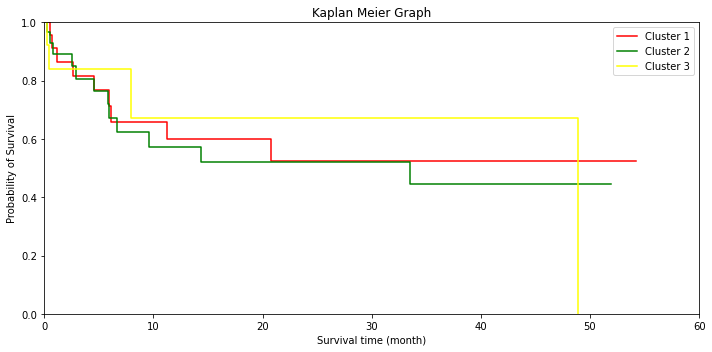

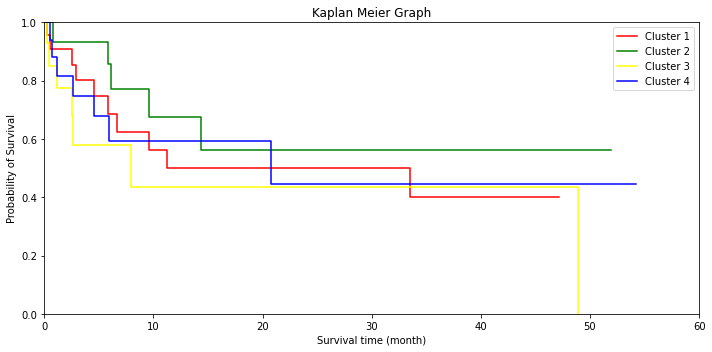

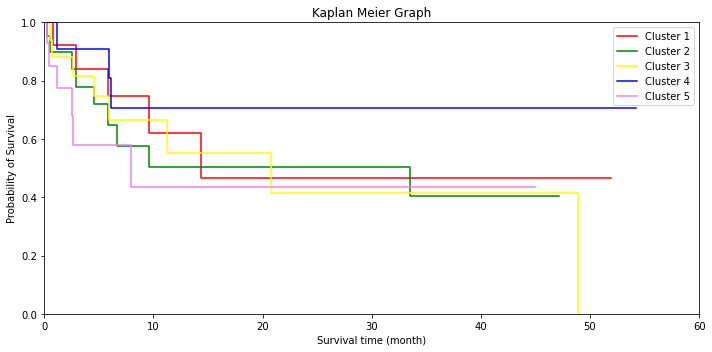

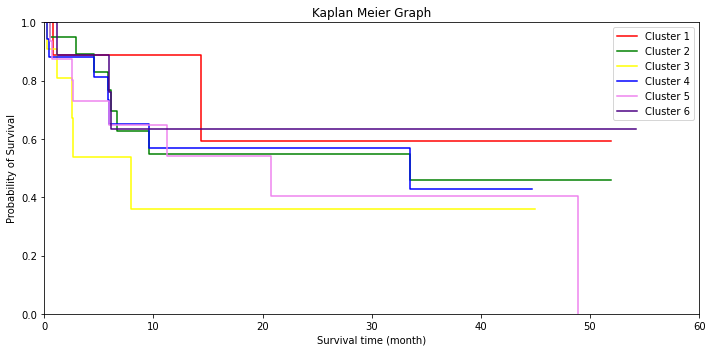

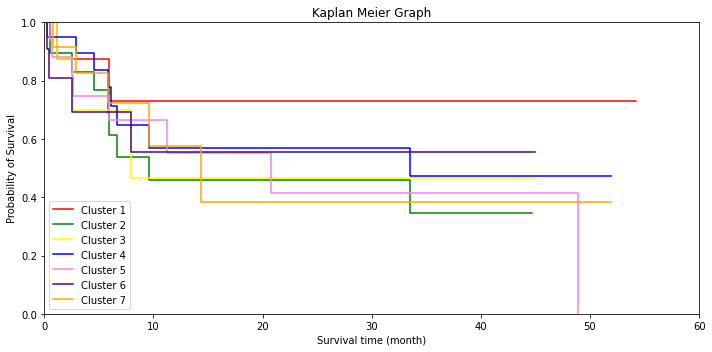

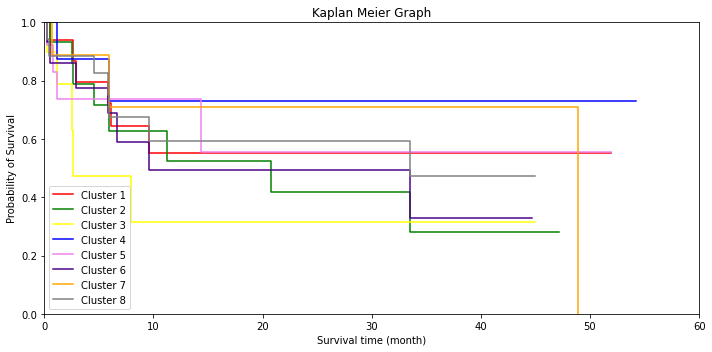

In [10]:
# Perform Kaplan Meier, Select the correct kmeans that shows best results from survival analysis, must have two completely seperetable survival lines
for i in range(3,9):
    labels = kmeans_dict[str(i)+'_Clusters']
    Clinical_data_new = KaplanMeierSurvivalFitter(labels , colors = colors , sample_ID_pixels = train_ID_pixels , Clinical_data = Clinical_data)

In [11]:
## Select the correct kmeans that shows best results from survival analysis, must have two completely seperetable survival lines
# 3 or 4 or 5 or 6 or 7 or 8 
selected_clusters_value = 8
# ----------------------------------------------------------------------------------

In [12]:
# Using Selected KMeans, apply LogRank test and Kaplan Meier to be used in Cox Hazard
selected_state = kmeans_dict[str(selected_clusters_value) + "_Clusters"]
labels = kmeans_dict[str(selected_clusters_value) + "_Clusters"]

Clinical_data_new = KaplanMeierSurvivalFitter(labels , colors = colors, sample_ID_pixels = train_ID_pixels , Clinical_data = Clinical_data)
plt.close()

Results = LogRankTest_PrintValues(labels , Clinical_data_new, printResults=False)

pvalue , SignCluster = SignificantClusters(labels, Results)


print("Significant Clusters are: Cluster " + str(SignCluster[0]+1) + " and Cluster " + str(SignCluster[1]+1))

Significant Clusters are: Cluster 3 and Cluster 4


Significant Clusters are:  [3 4]


Text(0.3, 0.05, 'P-value= 0.12')

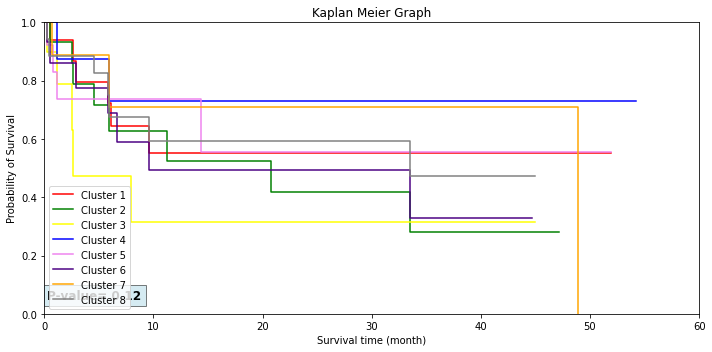

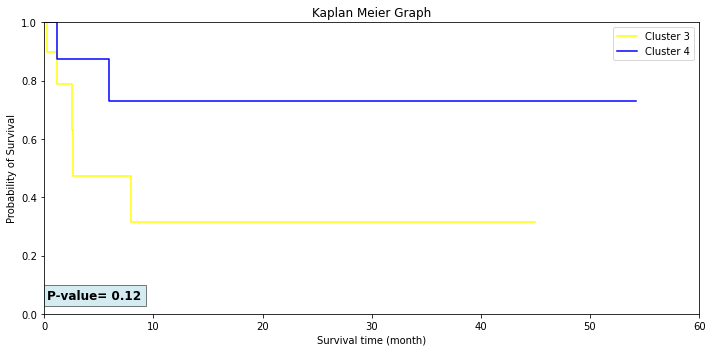

In [13]:
# Plot p-value with Kaplan Meier graphs of selected KMeans
print("Significant Clusters are: " , np.add(SignCluster,1))
SignCluster = [SignCluster[0] , SignCluster[-1]]

# Possible to manually input the Significant needed to be plotted
#SignCluster = [1 , 2 , 4 , 6 ]

Clinical_data_new = KaplanMeierSurvivalFitter(labels , colors = colors, sample_ID_pixels = train_ID_pixels, Clinical_data = Clinical_data)
plt.text(0.30,0.05, "{}{}".format("P-value= ", pvalue) , fontsize = 12,fontweight="bold",bbox = dict(facecolor = 'lightblue', alpha = 0.5))


Clinical_data_new= KaplanMeierSurvivalFitter(labels , colors = colors, sample_ID_pixels = train_ID_pixels, Clinical_data = Clinical_data,SignCluster=SignCluster)
plt.text(0.30,0.05, "{}{}".format("P-value= ", pvalue) , fontsize = 12,fontweight="bold",bbox = dict(facecolor = 'lightblue', alpha = 0.5))

In [14]:
# Apply CoxHazard Fitter
cph = CoxHazardFitter(labels , Clinical_data = Clinical_data_new)

labels_count = len(np.unique(labels))

Clusters = [ [] for _ in range(labels_count)]
for cluster_label in range(labels_count):
    Clusters[cluster_label] = Clinical_data_new.query("Belong_Cluster_" + str(cluster_label+1) + " == 1")

# Clears output, can be commented if needed
from IPython.display import clear_output
clear_output()
plt.close()

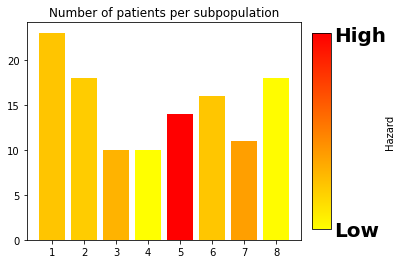

In [15]:
# Plot CoxHazard bar graph to show hazardous value of each cluster
labels_count = len(np.unique(labels))

Clusters = [ [] for _ in range(labels_count)]
for cluster_label in range(labels_count):
    Clusters[cluster_label] = Clinical_data_new.query("Belong_Cluster_" + str(cluster_label+1) + " == 1")
    
max_tick_value = max(cph.hazard_ratios_)
COLORS = ["yellow" , "red"]
CoxHazardBarPlot(cph = cph, colors = COLORS , max_tick_value = max_tick_value, clusters = Clusters)

<lifelines.CoxPHFitter: fitted with 62 total observations, 40 right-censored observations>
             duration col = 'Surv_time'
                event col = 'Surv_status'
                penalizer = 0.001
                 l1 ratio = 0.0
      baseline estimation = breslow
   number of observations = 62
number of events observed = 22
   partial log-likelihood = -71.03
         time fit was run = 2022-04-17 22:03:35 UTC

---
                   coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                
Belong_Cluster_1  -0.02       0.98       0.54            -1.07             1.03                 0.34                 2.81
Belong_Cluster_2   0.93       2.54       0.52            -0.09             1.95                 0.92                 7.06
Belong_Cluster_3   1.39       4.02       0.61             0.20             2.58                 1.22                13.20
Belong_Cluster_4  -0.51       0.60       0.76            -1.99             0.98                 0.14                 2.66
Belong_Cluster_5   0.58       1.78       0.68            -0.77             1.92                 0.46                 6.80
Belong_Cluster_6   1.10       3.02       0.56             0.00             2.20                 1.00                 9.07
Belong_Cluster_7   0.32       1.38       0.72            -1.09             1.72                 0.34                 5.61
Belong_Cluster_8  -0.26       0.77       0.51            -1.26             0.75                 0.28                 2.12

                     z    p   -log2(p)
covariate                             
Belong_Cluster_1 -0.04 0.97       0.04
Belong_Cluster_2  1.79 0.07       3.77
Belong_Cluster_3  2.29 0.02       5.51
Belong_Cluster_4 -0.67 0.50       0.99
Belong_Cluster_5  0.84 0.40       1.32
Belong_Cluster_6  1.97 0.05       4.35
Belong_Cluster_7  0.45 0.66       0.61
Belong_Cluster_8 -0.50 0.62       0.70
---
Concordance = 0.62
Partial AIC = 158.06
log-likelihood ratio test = 8.68 on 8 df
-log2(p) of ll-ratio test = 1.43

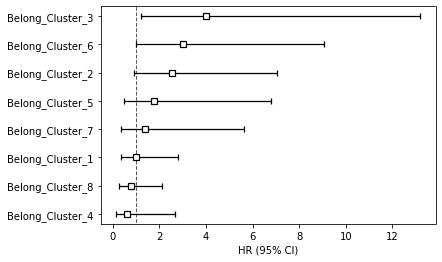

In [16]:
Clinical_data_coxHazard = Clinical_data_new.copy(deep=True)
Clinical_data_coxHazard.drop(["Sample_ID","T","N","M"],inplace = True,axis=1)
# print(Clinical_data_coxHazard)

# labels_count = len(np.unique(labels))
# Clusters = [ [] for _ in range(labels_count) ]

# for cluster_label in range(labels_count):
#     Clusters[cluster_label] = Clinical_data_coxHazard.query("Belong_Cluster_" + str(cluster_label+1) + " == 1")

# for cluster_label in range(labels_count):
#     Clinical_data_coxHazard.drop(["Belong_Cluster_" + str(cluster_label+1)],inplace = True,axis=1)
#     Clinical_data_coxHazard["Dead in Cluster " + str(cluster_label+1)] = Clusters[cluster_label]["Surv_status"]


# Clinical_data_coxHazard = Clinical_data_coxHazard.fillna(0)
# print(Clinical_data_coxHazard)
# Applying CoxHazard
cph=CoxPHFitter(penalizer=0.001)

cph.fit(Clinical_data_coxHazard, "Surv_time", "Surv_status")

cph.plot(hazard_ratios=True)
cph.print_summary()

#Clinical_data_coxHazard

In [66]:
# Check for signifiance between 2 clusters using cluster_value - 1 if needed
# Results[2][4]

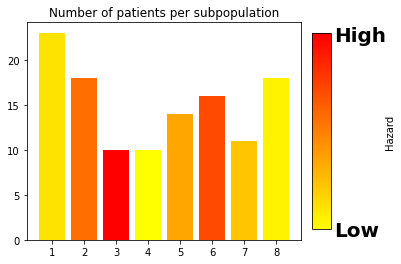

In [17]:
# Plot CoxHazard bar graph to show hazardous value of each cluster
labels_count = len(np.unique(labels))

Clusters = [ [] for _ in range(labels_count)]
for cluster_label in range(labels_count):
    Clusters[cluster_label] = Clinical_data_new.query("Belong_Cluster_" + str(cluster_label+1) + " == 1")
    
max_tick_value = max(cph.hazard_ratios_)
COLORS = ["yellow" , "red"]
CoxHazardBarPlot(cph = cph, colors = COLORS , max_tick_value = max_tick_value, clusters = Clusters)

In [68]:
# Using coxhazard to determine the significant clusters, check coxhazard before relying on these values
hazardous_cluster_label = np.argmax(cph.hazard_ratios_) # Find the max hazard ratio's index and that will be the hazardous cluster label
survival_cluster_label = np.argmin(cph.hazard_ratios_) # Find the min hazard ratio's index and that will be the highest survival cluster label

print("Hazardous cluster label's index is {} and it is cluster {}".format(hazardous_cluster_label,hazardous_cluster_label+1))
print("High Survival cluster label's index is {} and it is cluster {}".format(survival_cluster_label,survival_cluster_label+1))

Hazardous cluster label's index is 2 and it is cluster 3
High Survival cluster label's index is 3 and it is cluster 4


In [124]:
# Manual input cluster labels if needed
survival_cluster_label = 3
hazardous_cluster_label = 6

print("Hazardous cluster label's index is {} and it is cluster {}".format(hazardous_cluster_label,hazardous_cluster_label+1))
print("Survival cluster label's index is {} and it is cluster {}".format(survival_cluster_label,survival_cluster_label+1))

Hazardous cluster label's index is 6 and it is cluster 7
Survival cluster label's index is 3 and it is cluster 4


In [69]:
# Perform SAM Analysis, Run R file after this cell
protein_dataframe = SAM_Analysis(labels, Clinical_data, train_ID_pixels, hazardous_cluster_label, train_data, peak_list)
protein_dataframe.to_csv("GastricCancerAverageSpectrumValues.csv",index=False)

# Run R file in order to generate significant proteins using the csv file

In [60]:
#Need to read significant protein file outputted from R, Create Target labels to be used for KNN and SVM Models

SAM_protein = readSignificantProteins("significant_gastric_proteins.json",delete=False)
SAM_protein = SAM_protein + readSignificantProteins("significant_gastric_proteins_up.json",delete=False)

SAM_protein_indices=[]
for i in range(len(peak_list)):

    if peak_list[i][0] in SAM_protein:
        SAM_protein_indices.append(i)

train_scaled_selected_proteins_data = train_scaled_data[:,SAM_protein_indices]
test_scaled_selected_proteins_data = test_scaled_data[:,SAM_protein_indices]

train_selected_proteins_data = train_data[:,SAM_protein_indices]
test_selected_proteins_data = test_data[:,SAM_protein_indices]

train_labels = TargetLabelsCreation(labels , Clinical_data, train_ID_pixels, hazardous_cluster_label , survival_cluster_label)

print(SAM_protein)

[11355, 11315, 12354, 3482, 5003, 5145]


In [69]:
# SVM Model , predicting labels
# Test rbf at c = 0.1 , 1 , 10
# Test linear at c = 0.1 , 1 , 10
y_pred_SVM = SVM("rbf" , 10 , train_scaled_selected_proteins_data , train_labels , test_scaled_selected_proteins_data)

In [71]:
# Calculating SVM Probability survival values
Poor_Surv, Moderate_Surv , High_Surv = ProbabilityCalc(y_pred_SVM)
Surv_SVM = [Poor_Surv , Moderate_Surv, High_Surv]

Poor survival probability : 23.622217419494273 
Moderate survival probability : 63.907499459693106 
High survival probability : 12.47028312081262


In [70]:
# KNN Model, predicting labels
y_pred_KNN = KNN(10 , train_scaled_selected_proteins_data, train_labels, test_scaled_selected_proteins_data)

In [72]:
# Calculating KNN Probability values
Poor_Surv, Moderate_Surv , High_Surv  = ProbabilityCalc(y_pred_KNN)
Surv_KNN = [Poor_Surv , Moderate_Surv, High_Surv]

Poor survival probability : 26.25891506375621 
Moderate survival probability : 60.06051437216339 
High survival probability : 13.680570564080396


In [ ]:
# Selecting KNN as outputted results
# Selected Gastric probabilities, select KNN or SVM results
Selected_model = Surv_KNN
Poor_Surv = Selected_model[0]
Moderate_Surv = Selected_model[1]
High_Surv = Selected_model[2]

In [ ]:
# Run after model complete to save the result in the total results dataframe, outputting KNN results in dataframe
total_results_dataframe_KNN = OutputDataframe(total_results_dataframe_KNN, testPatient_ID , Clinical_data_full, Poor_Surv , Moderate_Surv, High_Surv ,selected_clusters_value, SAM_protein)

In [ ]:
# Preview KNN results
total_results_dataframe_KNN

In [ ]:
# Saving KNN results in CSV file
# Only run if needed to save and load at a later time
total_results_dataframe_KNN.to_csv("total_GastricCancer_results_KNN.csv" , index = False)

In [ ]:
# Selecting SVM as outputted results
# Selected Gastric probabilities, select KNN or SVM results
Selected_model = Surv_SVM
Poor_Surv = Selected_model[0]
Moderate_Surv = Selected_model[1]
High_Surv = Selected_model[2]

In [ ]:
# Run after model complete to save the result in the total results dataframe, outputting SVM results in dataframe
total_results_dataframe_SVM = OutputDataframe(total_results_dataframe_SVM, testPatient_ID , Clinical_data_full, Poor_Surv , Moderate_Surv, High_Surv ,selected_clusters_value, SAM_protein)

In [ ]:
# Preview SVM results
total_results_dataframe_SVM

In [ ]:
# Saving SVM results in CSV file
# Only run if needed to save and load at a later time
total_results_dataframe_SVM.to_csv("total_GastricCancer_results_SVM.csv" , index = False)